In [1]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import time

In [2]:
import os
import cv2

def extract_frames(video_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = 0

            # Read and process each frame
            while(cap.isOpened()):
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Perform your processing here to identify words and numbers in the frame
                # For simplicity, let's just save every 16th frame
                if frame_count % 16 == 0:
                    output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                    cv2.imwrite(output_frame_path, frame)

                frame_count += 1

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL YEAR PROJECT\\Dataset2.0"
output_frames_folder = "D:\\FINAL YEAR PROJECT\\Frames"
extract_frames(video_dataset_folder, output_frames_folder)


# ResNet50

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50

# Define constants
IMAGE_SIZE = (96, 72)
BATCH_SIZE = 16
EPOCHS = 400
NUM_CLASSES = 17
TRAIN_DATA_DIR = "D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\Frames"

# Define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load and preprocess the data with splitting
train_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 80% of the data will be used for training
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 20% of the data will be used for validation
)


Found 127 images belonging to 17 classes.
Found 22 images belonging to 17 classes.


In [1]:

# Define the ResNet50 model
model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Add new layers to the model
x = model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Combine the original model with the new layers
model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Start the timer
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Training Accuracy: {train_acc * 100}')
print(f'Validation Accuracy: {val_acc * 100}')
print(f'Trainig time: {comp_time}')



NameError: name 'ResNet50' is not defined

In [10]:
model.save('Resnet50_final.h5')

c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


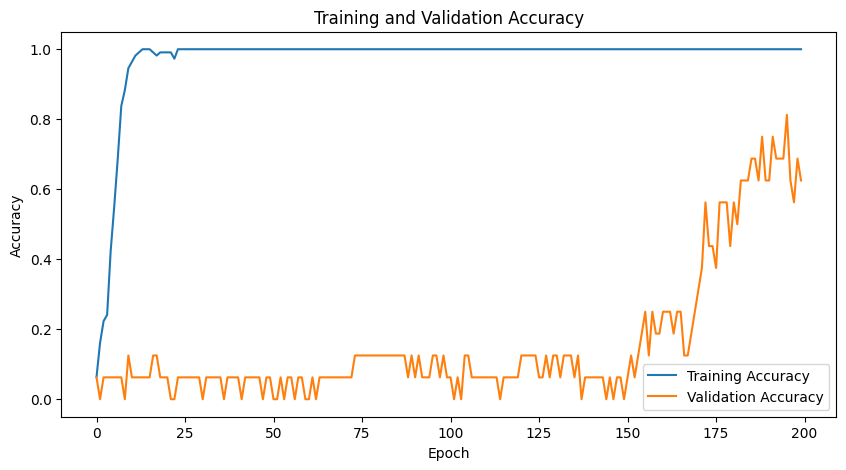

In [6]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

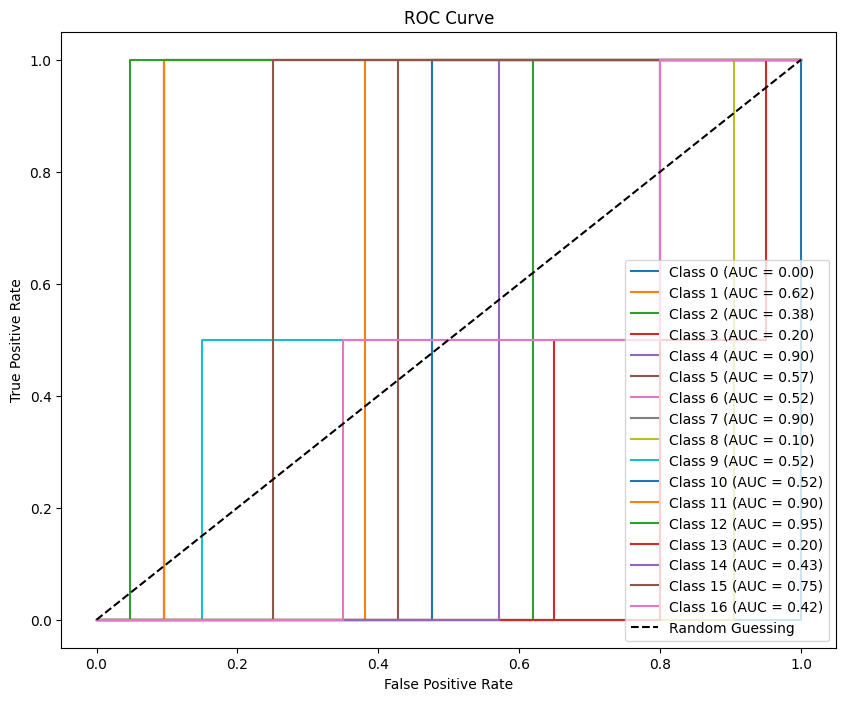

In [7]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


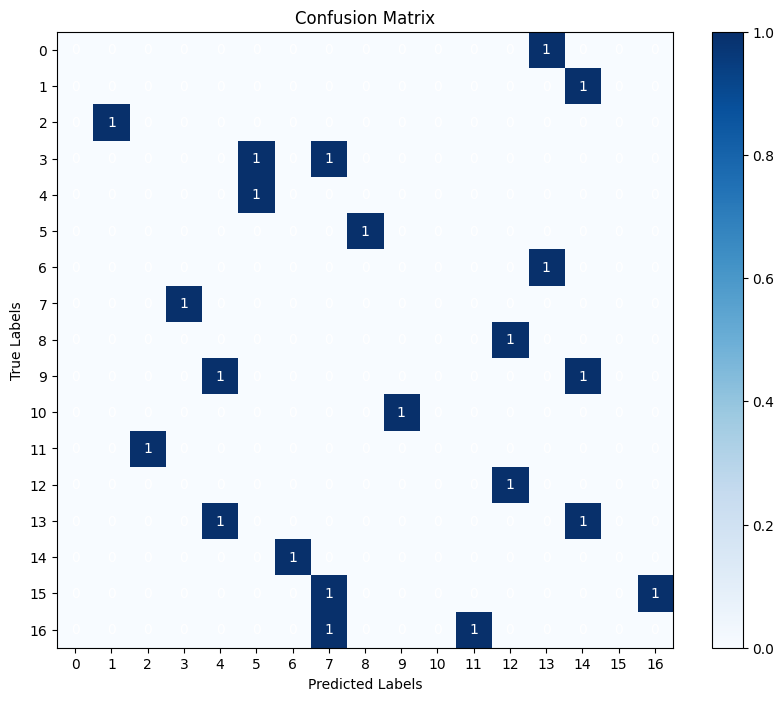

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable
# Evaluate the model
train_predictions = model.predict(train_generator)
validation_predictions = model.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Metric", "Precision", "Recall", "Sensitivity", "Specificity"]

print("Training Classification Report:")
print(train_report)

print("\nValidation Classification Report:")
print(validation_report)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, sensitivity, specificity
train_precision = np.diag(train_conf_matrix) / np.sum(train_conf_matrix, axis=0)
train_recall = np.diag(train_conf_matrix) / np.sum(train_conf_matrix, axis=1)
train_sensitivity = train_recall  # Sensitivity is the same as recall in binary classification
train_specificity = np.diag(train_conf_matrix) / (np.sum(train_conf_matrix) - np.sum(train_conf_matrix, axis=0))

validation_precision = np.diag(validation_conf_matrix) / np.sum(validation_conf_matrix, axis=0)
validation_recall = np.diag(validation_conf_matrix) / np.sum(validation_conf_matrix, axis=1)
validation_sensitivity = validation_recall  # Sensitivity is the same as recall in binary classification
validation_specificity = np.diag(validation_conf_matrix) / (np.sum(validation_conf_matrix) - np.sum(validation_conf_matrix, axis=0))

print("\nTraining Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training Sensitivity:", train_sensitivity)
print("Training Specificity:", train_specificity)

print("\nValidation Precision:", validation_precision)
print("Validation Recall:", validation_recall)
print("Validation Sensitivity:", validation_sensitivity)
print("Validation Specificity:", validation_specificity)

# Populate the table with training metrics
for class_name, precision, recall, sensitivity, specificity in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_sensitivity,
        train_specificity
):
    train_table.add_row([class_name, precision, recall, sensitivity, specificity])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Metric", "Precision", "Recall", "Sensitivity", "Specificity"]

# Populate the table with validation metrics
for class_name, precision, recall, sensitivity, specificity in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_sensitivity,
        validation_specificity
):
    validation_table.add_row([class_name, precision, recall, sensitivity, specificity])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)


Training Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.12      0.12      0.12         8
          10       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.25      0.25      0.25         8
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         7
         box       0.00      0.00      0.00         8
         fun       0.00      0.00      0.00         8
        good       0.22      0.22      0.22         9
        grow       0.00      0.00      0.00         8
        hero       0.12      0.12      0.12         8
       trust       0.00      0.00      0.00      

c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sumit\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sumit\A